# Handwritten Digits Generator With a GAN

In [1]:
# Dependensies
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)


In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Preparing the Training Data

In [6]:
"""
transforms.ToTensor() converts the data to a PyTorch tensor.
transforms.Normalize() converts the range of the tensor coefficients. suntract by 0.5 and divide by 0.5
"""

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [7]:
# Load the MNIST data and also transform it

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100.1%

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


32.8%%

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


100.4%

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


180.4%

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [9]:
# Dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


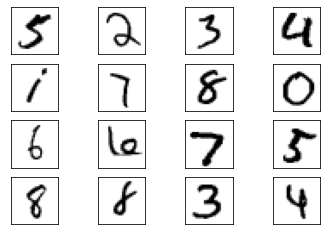

In [10]:
# Plot the training data

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Implementing the Discriminator and the Generator

In [11]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [14]:
# Load to the device cuda or cpu
discriminator = Discriminator().to(device=device)


In [15]:
# Generators

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # Tanh() as the activation of the output layer since the 
                       # output coefficients should be in the interval from -1 to 1. 
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

## Training the Models

To obtain a better result, you decrease the learning rate from the previous example. You also set the number of epochs to 50 to reduce the training time.

In [16]:
# set the parameters and the optimizers

lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [17]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5451085567474365
Epoch: 0 Loss G.: 0.5333892107009888
Epoch: 1 Loss D.: 0.09028621762990952
Epoch: 1 Loss G.: 4.402927398681641
Epoch: 2 Loss D.: 0.16547852754592896
Epoch: 2 Loss G.: 4.659501552581787
Epoch: 3 Loss D.: 0.023783911019563675
Epoch: 3 Loss G.: 4.915231227874756
Epoch: 4 Loss D.: 0.13356366753578186
Epoch: 4 Loss G.: 5.575718879699707
Epoch: 5 Loss D.: 0.10301870107650757
Epoch: 5 Loss G.: 4.015848159790039
Epoch: 6 Loss D.: 0.14672406017780304
Epoch: 6 Loss G.: 2.852285861968994
Epoch: 7 Loss D.: 0.33574241399765015
Epoch: 7 Loss G.: 2.6770527362823486
Epoch: 8 Loss D.: 0.31824976205825806
Epoch: 8 Loss G.: 2.0975141525268555
Epoch: 9 Loss D.: 0.40259796380996704
Epoch: 9 Loss G.: 2.364253520965576
Epoch: 10 Loss D.: 0.3554280400276184
Epoch: 10 Loss G.: 1.8860251903533936
Epoch: 11 Loss D.: 0.4092288017272949
Epoch: 11 Loss G.: 1.5370371341705322
Epoch: 12 Loss D.: 0.25355827808380127
Epoch: 12 Loss G.: 1.797617793083191
Epoch: 13 Loss D.: 0.36506885

## Checking the Samples Generated by the GAN

In [18]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

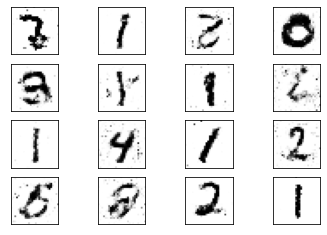

In [19]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])